# Stock Correlation

This notebook analyses an often heard hypothesis of stock correlations: There are stocks which follow in their trends one after an other within a short time window. If such correlations are predictable, we can exploit them for buy/sell signals. 

Our analysis looks for such correlations and discuss whether they are predictable.

## Evaluation and Predictability

This notebook takes the probabilities for correlated stocks from [stock_correl.ipynb](stock_correl.ipynb) and evaluates them statistically. The correlation analysis yields $P(R2>x|S1>c)$, that is the probability  that stock2's return is larger than $x\%$, given stock1's slope exceeds a given limit $c$. This tells us some believe in the slope/return correspondence or correlation hypothesis. 

However, the number alone is not necessarily useful, because the condition $S1>c$ constrains the probability. Say, $S1>c$ occurs rarly and in those situations we often find a high return for stock2 shortly afterwards, as a result, we will have a high probability. However, to exploit the slope/return correspondence, we need to know if the condition is predictable. 

Note, we do not want to predict when the condition $S1\gt c$ appears, but investigate its predictability. So, we are not interested in a prediction model, but rather in properties to guide the development of a prediction model.

At the beginning we review selected results from the previous notebook. Afterwards, we investigate the following approaches to evaluate predictability:

* Entropy
* $\chi^2$ Testing
* Poisson Analysis using Bayesian Statistics

### Parameters

In [1]:
input_file = './SMI.CH_IXX.DE_stats.parquet'
dataset_file = './SMI.CH_IXX.DE.parquet'

input_file = '/YASMaPE/data/stock_correl/results/MUX.DE_IXX.DE_stats.parquet'
dataset_file = '/YASMaPE/data/stock_correl/intermediate/MUX.DE_IXX.DE.parquet'

### Imports

In [2]:
# libs we need
import os
import pandas as pd
import statsmodels.api as sm
import numpy as np
import statistics
from statsmodels.distributions.empirical_distribution import ECDF
import scipy.stats as stats

# plotting
import matplotlib.pyplot as plt
import math

# date calculations
from datetime import datetime
from datetime import timedelta

# optimize, credible interval computation
from scipy import optimize

Extract stock names from `input_file` name.

In [3]:
bname = os.path.basename(input_file)
# s1_s2_XXX.parquet -> s1_s2
str_list = bname.split('_',2)
str_list.pop()
bname = "_".join(str_list)

# s1_s2 -> s1 s2
stock_names = [s for s in bname.split('_',1)]
stock1_name = stock_names[0]
stock2_name = stock_names[1]

### Load Data

Load data from `.parquet` file.

In [4]:
stock2_returns = pd.read_parquet(input_file)

# Summary stats
print('Data rows in {}: {}'.format(input_file, len(stock2_returns)))

Data rows in /YASMaPE/data/stock_correl/results/MUX.DE_IXX.DE_stats.parquet: 60


In [5]:
thr_limits = list(stock2_returns['thr_stock1'])

We need the stock1/stock2 correspondence data from the dataset file as well.

In [6]:
stock_correspond = pd.read_parquet(dataset_file)

# Summary stats
print('Data rows in {}: {}'.format(input_file, len(stock_correspond)))

# only consider real slopes, i.e. slopes which significantly differ from 0 
stock_correspond = stock_correspond[stock_correspond['H0_rejected_stock2'] == True]
stock_correspond = stock_correspond[stock_correspond['H0_rejected_stock1'] == True]
print('Data samples for stock correspondences of {}/{} : {}'.format(stock1_name, stock2_name, len(stock_correspond)))

Data rows in /YASMaPE/data/stock_correl/results/MUX.DE_IXX.DE_stats.parquet: 198750
Data samples for stock correspondences of MUX.DE/IXX.DE : 89761


In [7]:
slopes = stock_correspond[['slope_stock1', 'slope_stock2', 'win_length_stock1', 'win_length_stock2', 'return_stock2']].reset_index(drop=True)
slopes['win_diff'] = slopes['win_length_stock1'] - slopes['win_length_stock2']

### Review: Probabilities

We review results from the previous notebook and plot the probabilities that stock2 decreases, i.e. $S2 \leq 0.0$, or $R2$ exceeds more than $10\%$, if stock's $S1$ slope exceeds a certain threshold.

Text(0.5, 1.0, 'Probability that IXX.DE achieves return greater 10%')

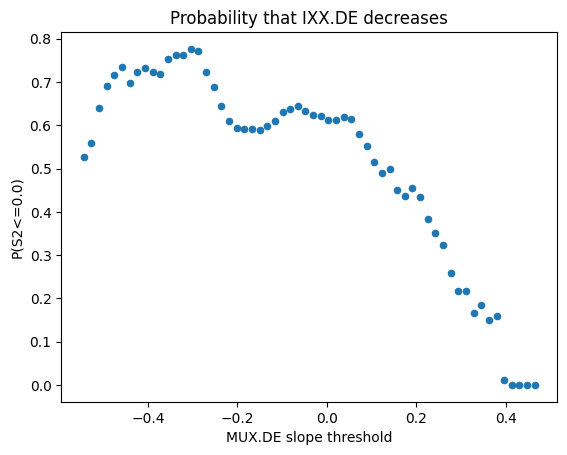

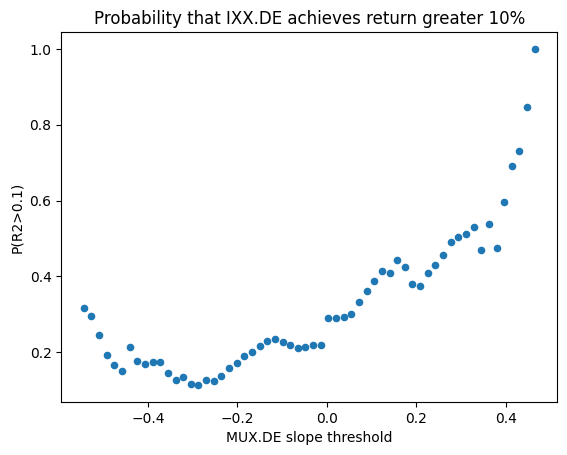

In [8]:
ax1 = stock2_returns.plot.scatter(x='thr_stock1', y='P(S2<=0.0)')
ax1.set_xlabel('{} slope threshold'.format(stock1_name))
ax1.set_title('Probability that {} decreases'.format(stock2_name))

ax1 = stock2_returns.plot.scatter(x='thr_stock1', y='P(R2>0.1)')
ax1.set_xlabel('{} slope threshold'.format(stock1_name))
ax1.set_title('Probability that {} achieves return greater 10%'.format(stock2_name))

In [9]:
# Probability that S2 decreases is less than threshold
P_S2_leq_0_threshold = 0.25

# get the index where this threshold holds
# implicit assumption: 
# P_S2 monotonically decreases from this threshold on
P_S2_leq_0 = stock2_returns[stock2_returns['P(S2<=0.0)']<P_S2_leq_0_threshold].sort_values('P(S2<=0.0)', ascending=False).head(1)
P_S2_leq_0_idx = P_S2_leq_0.index[0]
P_S2_leq_0

,thr_stock1,P(S2<=0.0),P(R2>0.05),P(R2>0.1),P(R2>0.15),P(R2>0.2),P(R2>0.25),P(R2>0.3),P(R2>0.35),P(R2>0.4),...,P(R2>0.5),P(R2>0.55),P(R2>0.6),P(R2>0.65),P(R2>0.7),P(R2>0.75),P(R2>0.8),P(R2>0.85),P(R2>0.9),P(R2>0.95)
49,0.294224,0.216877,0.721609,0.503155,0.171136,0.033123,0.009464,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Review: First Results and Discussion

We start with some conrete example results derived from the systematic analysis. In all examples, we provide results under the condition $S_1 \ge c$, where $c$ is the last threshold limit from previous analysis.

At the end, we also discuss quality of our results for prediction tasks.

In [10]:
# the slope threshold we use for all result discussions
c = thr_limits[-1]

In [11]:
c = stock2_returns.iloc[P_S2_leq_0_idx]['thr_stock1']

In [12]:
print('In the case, the {} slope is larger than {}, we find:\n'.format(stock1_name,c))

# Compute probabilities
row = stock2_returns[stock2_returns['thr_stock1'] == c]
x = 0.0
prob = row['P(S2<={})'.format(x)].iloc[0]
print('\t* Probability of {} decreasing is {}%.'.format(stock2_name, round(prob*100,2)))
x_stock2_returns = [0.05, 0.1, 0.15, 0.2]
for x in x_stock2_returns:
    prob = row['P(R2>{})'.format(x)].iloc[0]
    print('\t* Probability of {} return > {}% is {}%.'.format(stock2_name, x*100, round(prob*100,2)))

In the case, the MUX.DE slope is larger than 0.29422406763110054, we find:

	* Probability of IXX.DE decreasing is 21.69%.
	* Probability of IXX.DE return > 5.0% is 72.16%.
	* Probability of IXX.DE return > 10.0% is 50.32%.
	* Probability of IXX.DE return > 15.0% is 17.11%.
	* Probability of IXX.DE return > 20.0% is 3.31%.


Let's plot the distributions of stock2's slopes and returns.

In the case, the MUX.DE slope is larger than 0.29422406763110054, we find:

Avg. slope of IXX.DE: 0.20521491378987172
Avg. return of IXX.DE: 0.07256943875655825


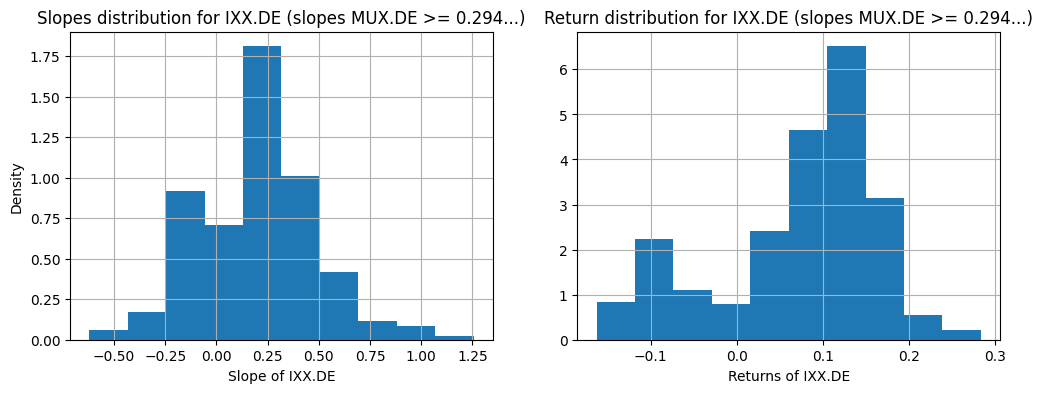

In [13]:
# select the results for stock1's slope exceeding c
slopes_stock1_gt_c = slopes[slopes['slope_stock1'] > c]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
slopes_stock1_gt_c.slope_stock2.hist(density=True, ax=axes[0])
axes[0].set_title('Slopes distribution for {} (slopes {} >= {}...)'.format(stock2_name, stock1_name, round(c,3)))
axes[0].set_xlabel('Slope of {}'.format(stock2_name))
slopes_stock1_gt_c.return_stock2.hist(density=True, ax=axes[1])
axes[1].set_title('Return distribution for {} (slopes {} >= {}...)'.format(stock2_name, stock1_name, round(c,3)))
axes[1].set_xlabel('Returns of {}'.format(stock2_name))
axes[0].set_ylabel('Density')

# Some stats for both
mean_slope_stock2 = statistics.mean(slopes_stock1_gt_c['slope_stock2'])
mean_return_stock2 = statistics.mean(slopes_stock1_gt_c['return_stock2'])

print('In the case, the {} slope is larger than {}, we find:\n'.format(stock1_name,c))
print('Avg. slope of {}: {}'.format(stock2_name, mean_slope_stock2))
print('Avg. return of {}: {}'.format(stock2_name, mean_return_stock2))

At the first glance, the findings from above look promising. However, these results stem from the past. They do not tell us anything about the prediction quality. 
Firstly, it is rather rare for stock's slope to exceed the threshold from the above example. Secondly, slopes exceeding the thresholds may have just occured in the near past. Previous to that the slopes may have not shown this behavior.

As a consequence, we have additional requirements.

1. Split data into two sets: one for analysis and one for testing the analysis results. 
1. Conditions, e.g. slopes exceeding the thresholds, are not just found in one short time intervall over all observations. Rather, these conditions shall be distributed across all observations from analysis data set.

### Stock1 Slope Pattern in the Slope/Return Correspondence

In order to exploit our findings about the slope/return correspondence, we are interested in the temporal distribution of those stock1 slopes which corresponds to the large stock2 returns. 

Just to illustrate the distribution, we show how rare slopes with a threshold limit larger than $c$ are. 

In [14]:
# slopes exeeding thresholds are rare
num_obs = len(set(stock_correspond.reset_index()['date_stock1'])) 
s = stock_correspond.reset_index()[['date_stock1', 'slope_stock1']]
s = s[s['slope_stock1'] >= c]
num_slopes = len(set(s['date_stock1']))

print('Number of observation days: \t\t{}'.format(num_obs))
print('Number of slopes exceeding {}: \t{}'.format(round(c,3),num_slopes))

Number of observation days: 		337
Number of slopes exceeding 0.294: 	24


How do the days with exceedings slopes distribute across all observations days? Do they cluster?

In [15]:
stock1_dates = list(set(stock_correspond.reset_index()['date_stock1']))
stock1_dates.sort()
not_exceeds_c = [False] * len(stock1_dates)
df_not_exceeds_c = pd.DataFrame(data=not_exceeds_c, index=stock1_dates, columns=['not_exceeds_c'])

slope_dates = list(set(s['date_stock1']))
slope_dates.sort()
exceeds_c = [True] * len(slope_dates)
df_exceeds_c = pd.DataFrame(data=exceeds_c, index=slope_dates, columns=['exceeds_c'])

In [16]:
print('The {} dates where the {} slopes >= {}'.format(len(slope_dates), stock1_name, c))
slope_dates

The 24 dates where the MUX.DE slopes >= 0.29422406763110054


['2022-03-03',
 '2022-03-04',
 '2022-03-07',
 '2022-03-08',
 '2022-03-09',
 '2022-03-10',
 '2022-03-11',
 '2022-03-14',
 '2022-03-15',
 '2022-05-24',
 '2022-05-25',
 '2022-05-26',
 '2022-05-27',
 '2022-07-13',
 '2022-07-14',
 '2022-07-15',
 '2022-11-02',
 '2022-11-03',
 '2022-11-04',
 '2022-11-07',
 '2022-12-27',
 '2022-12-28',
 '2022-12-29',
 '2022-12-30']

Visualize above dates using a histogram across all observation days.

In [17]:
# join frames together and replace all NaN with False
df = df_not_exceeds_c.join(df_exceeds_c).fillna(False)
df = df.drop(['not_exceeds_c'], axis=1)
df = df.reset_index() # retrieve date from stock1
df = df.rename(columns={'index':'date_stock1'})
df = df.assign(days_back=list(range(-len(df)+1,1))) # enumerate date as dates in the past

Text(0.5, 0, 'Days back from last observation day 2023-02-09')

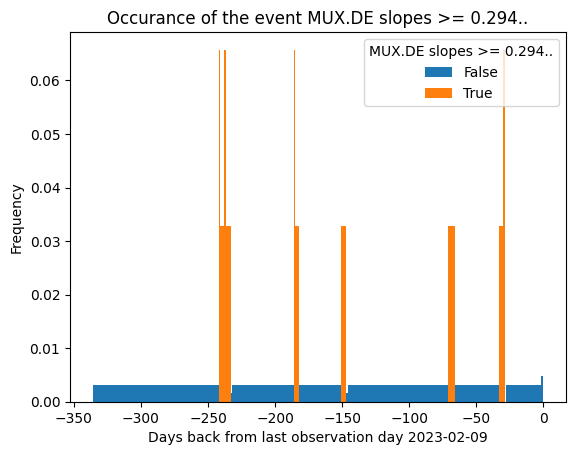

In [18]:
# plot as histogram
df.groupby('exceeds_c')['days_back'].plot(kind='hist', bins=int(len(df)/2), density=True)
plt.title('Occurance of the event {} slopes >= {}..'.format(stock1_name, round(c,3)))
plt.legend(['False', 'True'], title='{} slopes >= {}..'.format(stock1_name, round(c,3)))
plt.xlabel('Days back from last observation day {}'.format(stock1_dates[-1]))

## Predictability

We would like to estimate to some level of confidence, that the observed stock1 slopes will happen in the near future. Since we do not know the data generating process for stock1 slopes, predictability arises only  from the regularity of past event occurences, that is the occurence of stock1 slopes exceeding a certain threshold. This is rather simple, but a regular reoccuring pattern of events can be expected to continue in the future. Although this continuity is only speculative, we want to formulate a confidence measure which tells random occurence and a reoccuring pattern apart. 

This is guided by the following intuition: The more often or regular the events have occurred in the past, we have a higher confidence they will repeat in the near future. If those events were rather rare in the past, well, they might have appeared by chance and it is unlikely we see them again in the near future other than just by pure chance.

### Entropy Measure for Predictability

In this section we use an entropy measure to quantify predictability by investigating the regularity in which days with slope larger than $c$ occur. Here, the [Shannon entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)) is used as information measure, that is informally the amount of "information, "surprise" or "uncertainty" of a discrete random variable's outcome measured in bits. A highly likely event provides less information or surprise than an unlikely event, because we basically _know_ that the event occurs. So, it does not come to our suprise.

In our case, the random variable measures an event occurance in a time interval. The variable's values are the different time intervals. Let's say we have 8 intervals. In each interval an event may occur with a certain probability. All probabilities need to sum to $1$. If the probability in each interval is the same, it will yield an entropy of $log_2(8) = 3$. So, we need 3 bits to encode *all* event patterns across $8$ intervals. If the sequence of events is alternating, that is $0.25, 0, 0.25, 0, 0.25, 0, 0.25, 0$ with probability of $0.25$, we will need only $2$ bits to encode *all* event occurance patterns within $8$ intervals. The reason is that we know that in every second interval the event will definitely not occur. So, it does not not come to our surprise, that the number of different event patterns is less, resulting in a smaller entropy. If the event only occurs in the first interval, the entropy is $0$, because there is only one pattern of event occurance.

The approach applying the Shannon entropy information measure is to form bins from equi-distant time intervals and count the occurance of events in each bin. An event occurs when the stock1 slope is larger than a threshold limit $c$ within the bin. 

Let $b \in \mathcal{B}$ the bins and $p(b)$ the relative frequency that of events in bin $b$. The Shannon entropy is

$$
H = -\sum_{b \in \mathcal{B}} p(b)log_2p(b)
$$

So, by changing the bin size, more or less events are allocated within a bin. A regular pattern may emerge, when the bin size is chosen so that the same number of events occur in each bin. Such a pattern has the maximal entropy, because the events do not cluster in certain bins, but are uniformly smeared across all bins. 

This may seem counter-intuitive. One could argue: If I know for sure that the event occurs in each bin, there is no surprise. As a consequence, the entropy is at its minimum value $0$. However, the phrase "for sure" denies the random nature of event occurance within bins. The overall number of events is fixed, because we have already observed them. So, I know for sure the number of events which have ocuured. Changing bins, allocates events randomly in different observation intervals. Predictability arises from the regularity of past event occurance, because that is a good prerequisite to extrapolate the event occurance pattern into the future.

The more bins, each with smaller width, we define, the less likely it is that we find an event within a bin given a fixed overall number of events to be distributed on an increasing number of bins. So, this increases our a-priori knowledge that there is no event in bin. Therefore, more bins will decrease the entropy. The overall number of events yields an optimal entropy of $log_2(\#\textrm{events})$, that is the number of bits when events distribute uniformly. The number of bins requires an entropy of $log_2(\#\textrm{bins})$, if events need to be distributed uniformly. 

**Problem description:** Find an equi-distant bin distribution with optimal entropy. That is the number of equi-distant bins 

1. will let the entropy $H$ be close to $log_2(\#\textrm{events})$, 
1. $log_2(\#\textrm{bins})$ induced by the number of bins will be close to $log_2(\#\textrm{events})$

Both conditions above will smear out the events across the bins. The result of this optimization is a number of _equi-distant bins_ where the events are allocated as uniformely as possible across all bins.

The code below tests the entropy for varying bin sizes and find the optimal one. 

In [19]:
days_back_exceeds_c = df[df['exceeds_c']==True].days_back
num_days_back_exceed_c = len(days_back_exceeds_c)

first_day_exceeds_c = days_back_exceeds_c.iloc[0]
last_obs_day = df.iloc[-1].days_back

In [20]:

######################################################
# Helper functions
######################################################
#
# compute equi-distant edges
def _bin_edges(num_bins):
    return np.linspace(first_day_exceeds_c, last_obs_day, num_bins+1)

# compute bin frequencies
def _hist_freq_bins(bin_edges):
    freq, freq_bin_edges = np.histogram(days_back_exceeds_c.values, bins=bin_edges, density=False)
    freq = freq.astype(float)
    freq /= num_days_back_exceed_c
    return freq, freq_bin_edges

# entropy (= num of bits) for 
# ... event pattern given the num_bins, 
# ... signal days - bits to encode the number of days we have a pattern signal
# ... number of bins - bits to encode the event pattern, if events may occur in each bin  
def _bit_entropy(freq, num_bins, num_signal_days=num_days_back_exceed_c, base=2):
    H = stats.entropy(freq, base=base)
    Hbits = H
    Sbits = math.log(num_signal_days,base)
    Bbits = math.log(num_bins,base)
    return Hbits, Sbits, Bbits

######################################################
    
# initialize 
res_stock1_slope_entropy = []
min_dist = math.ceil(math.log(-first_day_exceeds_c,2))
best_num_bins = -1

# all bins to loop through
all_bins = range(1, -days_back_exceeds_c.iloc[0]+1)
# loop through all bin numbers
for num_bins in all_bins:
    bin_edges = _bin_edges(num_bins)
    
    # compute bin frequencies
    freq, freq_bin_edges = _hist_freq_bins(bin_edges)
    
    # compute entropy
    Hbits, Sbits, Bbits = _bit_entropy(freq, num_bins=num_bins)
    
    # compute the L2 norm of the vector (a_1, a_2), with
    # a_1 = signal bits - pattern bits (implements 1. from problem description)
    # a_2 = bin bits - signal bits (implements 2. from problem description)
    a = np.array((round(Sbits-Hbits,2), round(Bbits-Sbits,2)))
    dist = np.linalg.norm(a)
    # log minimal dist and its bin
    if dist < min_dist:
        min_dist = dist
        best_num_bins = num_bins
    
    # store results
    res_stock1_slope_entropy.append((num_bins, dist, Hbits, Sbits, Bbits))

In [21]:
# compile dataframe from result list
num_bins_indices = [num_bin for num_bin in list(zip(*res_stock1_slope_entropy))[0]]
colnames = ['num_bins', 'dist', 'Hbits', 'Sbits', 'Bbits']
stock1_slope_entropy = pd.DataFrame(data=res_stock1_slope_entropy, columns=colnames, index=num_bins_indices).dropna()
stock1_slope_entropy.index.name = colnames[0]
stock1_slope_entropy = stock1_slope_entropy.drop(labels=stock1_slope_entropy.index.name, axis=1)

In [22]:
# compute entropy for best number of bins
freq, freq_bin_edges = _hist_freq_bins(_bin_edges(best_num_bins))
Hbits, Sbits, Bbits = _bit_entropy(freq, num_bins=best_num_bins)

print('Best number of bins: {}\n'.format(best_num_bins))
print('Entropy of event pattern [bit] / signal days [bit] / bins [bit]:\n{} / {} / {}'.format(Hbits, Sbits, Bbits))

Best number of bins: 39

Entropy of event pattern [bit] / signal days [bit] / bins [bit]:
2.901363669197544 / 4.584962500721157 / 5.285402218862249


In [23]:
print('Frequencies per bin and bin endges:')

freq, freq_bin_edges

Frequencies per bin and bin endges:


(array([0.29166667, 0.08333333, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.16666667,
        0.        , 0.        , 0.        , 0.        , 0.08333333,
        0.04166667, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.08333333, 0.08333333, 0.        ,
        0.        , 0.        , 0.        , 0.04166667, 0.125     ,
        0.        , 0.        , 0.        , 0.        ]),
 array([-242.        , -235.79487179, -229.58974359, -223.38461538,
        -217.17948718, -210.97435897, -204.76923077, -198.56410256,
        -192.35897436, -186.15384615, -179.94871795, -173.74358974,
        -167.53846154, -161.33333333, -155.12820513, -148.92307692,
        -142.71794872, -136.51282051, -130.30769231, -124.1025641 ,
        -117.8974359 , -111.69230769, -105.48717949,  -99.28205128,
         -93.07692308,  -86.87179487,  -80.66666667,  -74.

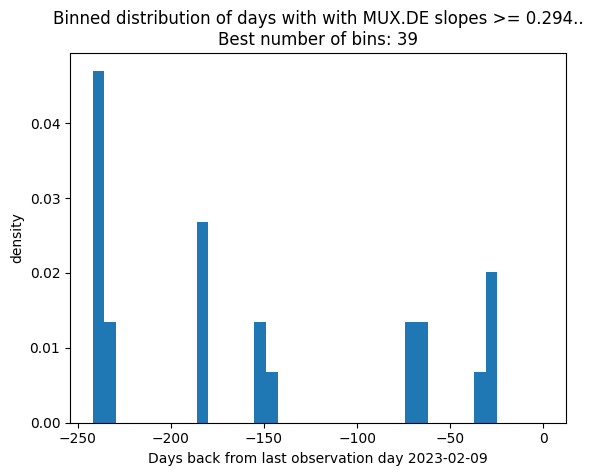

In [24]:
# plot bins and their event frequencies 
plt.hist(days_back_exceeds_c, bins = freq_bin_edges, density=True) 
plt.title('Binned distribution of days with with {} slopes >= {}..\nBest number of bins: {}'.format(stock1_name, round(c,3), best_num_bins)) 
plt.xlabel('Days back from last observation day {}'.format(stock1_dates[-1]))
plt.ylabel('density')
plt.show()

### Result: Entropy Measure for Predictability

The problem was to find an equi-distant bin distribution with optimal entropy. That is the number of equi-distant bins 

1. will let the entropy $H$ be close to $log_2(\#\textrm{events})$, 
1. $log_2(\#\textrm{bins})$ induced by the number of bins will be close to $log_2(\#\textrm{events})$


In [25]:
print("The number of equi-distant bins with the optimal entropy is: {}".format(best_num_bins))
print("The bin width is {} days.".format(round(0-freq_bin_edges[-2],2)))

The number of equi-distant bins with the optimal entropy is: 39
The bin width is 6.21 days.


**Other Ideas**

Using the Shannon entropy measure is not the only approach to quantify the prediction quality. Other definitions of entropy may apply as well, such as [approximate entropy](https://en.wikipedia.org/wiki/Approximate_entropy) or [sample entropy](https://en.wikipedia.org/wiki/Sample_entropy). A classical alternative is a [Discrete Fourier Transformation (DFT)](https://en.wikipedia.org/wiki/Discrete_Fourier_transform) to regress the event occurance pattern as a sum of sin/cosine frequencies.

### $\chi^2$ Test for Uniformity

When stock1 slope exceeds a given limit $c$, we call it an event occurrence. Since we do not know the data generating process for stock1 slopes, predictability arises only  from the regularity of past event occurences. In this section we consider regularity as close to a uniform distribution. 

We divide the observation days in $b$ bins of equal size. The value $n_i$ is the absolute count of events within a bin $b_i$.

The $\chi^2$ test tests the null hypothesis H0: the distribution of events is uniform.

In [26]:
# re-create relevant variables 
# overwrites any changes from previous section
days_back_exceeds_c = df[df['exceeds_c']==True].days_back
num_days_back_exceed_c = len(days_back_exceeds_c)

first_day_exceeds_c = days_back_exceeds_c.iloc[0]
last_obs_day = df.iloc[-1].days_back

In [27]:
# store chi2 pvalues for different num of bins
res_stock1_slope_chi2 = []

all_bins = range(1, -days_back_exceeds_c.iloc[0]+1)
# loop through all bin numbers
for num_bins in all_bins:
    bin_edges = _bin_edges(num_bins)
    # n absolute number of occurrence; n_bin_edges the left-side value of the bin limit
    n, n_bin_edges = np.histogram(days_back_exceeds_c.values, bins=bin_edges, density=False)
    
    # expected occurances n_exp, when all observations are uniformly distributed across num_bins
    n_exp = num_bins * [sum(n)/num_bins]
    _, pvalue = stats.chisquare(n) # no need for f_exp, since we test for uniform distribution
    res_stock1_slope_chi2.append((num_bins, min(n), pvalue))

The $\chi^2$ statistic is sensitive to sample size. It is recommended to have at least 5 samples per bin and a total of more than 20. For a later consideration, we include the minimum number of samples in a bin in the result dataset.

In [28]:
# compile dataframe from result list
num_bins_indices = [num_bin for num_bin in list(zip(*res_stock1_slope_entropy))[0]]
colnames = ['num_bins', 'min_n', 'chi2_pvalue']
stock1_slope_chi2 = pd.DataFrame(data=res_stock1_slope_chi2, columns=colnames, index=num_bins_indices).dropna()
stock1_slope_chi2.index.name = colnames[0]
stock1_slope_chi2 = stock1_slope_chi2.drop(labels=stock1_slope_chi2.index.name, axis=1)

### Result: $\chi^2$ Test

The $\chi^2$ test tests the null hypothesis H0: the distribution of $S1\gt c$ events is uniform.
We provide the best result, i.e., maximum p-value for a sample size of more that 5 events per bin. Remember, we need to consider the sample size due to the sensitivity of the $\chi^2$ test.

In [29]:
chi2_res = stock1_slope_chi2[stock1_slope_chi2['min_n']>0]
try:
    min_chi2_pvalue_idx = chi2_res.idxmax()['chi2_pvalue']
    chi2_res = chi2_res.loc[min_chi2_pvalue_idx]

    print("Number of bins: {}".format(chi2_res.name))
    print("There are at least {} events in a bin.".format(int(chi2_res['min_n'])))
    pv = round(chi2_res['chi2_pvalue']*100,1)
    print("Probablity to see the event pattern given H0 is true: {}%".format(pv))
except:
    print("No result found.")

Number of bins: 2
There are at least 8 events in a bin.
Probablity to see the event pattern given H0 is true: 10.2%


### Poisson Analysis using Bayesian Statistics

We estimate $\lambda$ parameter of a Poisson distribution as the data generating process for the occurrences of days with stock1 slope exceeding a given limit $c$. This approach deviates from our setup for the evaluation of predicatability. Originally, we said, we do not know the data generating process.

In this analysis, we follow a _bayesian approach_ in that we want to know the distribution of the $\lambda$ parameter. Utilizing bayesian data analysis, the Poission distribution is the likelihood, $P(x|\lambda)$ of the event data $x$, and we are interested in 

1. posterior distribution $P(\lambda | x)$
1. posterior predictive distribution $P(\hat{x}|x)$


Let the random variable $X$ be the number of occurances with stock1 slope exceeding $c$ within the binned distribution of all observation days. The number of bins $b$ is a hyperparameter. 

It is $X\sim Poisson(\lambda)$. The unbiased point estimator for $\hat{\lambda} = \frac{1}{b}\sum_i x_i$, where $x_i$ is the absolute number of occurences of stock1 slope exceeding $c$ in bin $i$.

In [30]:
num_bins = best_num_bins
bin_edges = _bin_edges(num_bins)
x, x_bin_edges = np.histogram(days_back_exceeds_c.values, bins=bin_edges, density=False)
print("\nEvents counts n_i for each bin: {}".format(x))
print("MLE point estimator, lambda hat: {}\n".format(x.mean()))


Events counts n_i for each bin: [7 2 0 0 0 0 0 0 0 4 0 0 0 0 2 1 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 1 3 0 0
 0 0]
MLE point estimator, lambda hat: 0.6153846153846154



#### Bayesian Analysis

We compute an interval estimate for the mean of binned event occurences. The standard deviation is unknown. The method `bayes_mvs` produces a posterior distribution and returns the mean as well as the $\alpha$ credibility interval. It utilizes a "non-informative" prior that makes no assumptions about the mean or variance. For small sample sizes this prior is a t-distribution, otherwise a normal distribution. See [`bayes_mvs`(src)](https://github.com/scipy/scipy/blob/v1.10.1/scipy/stats/_morestats.py#L45-L141) and [`mvsdist`(src)](https://github.com/scipy/scipy/blob/v1.10.1/scipy/stats/_morestats.py#L144-L216) for details.

In [31]:
# Bayesian confidence intervals for the mean (lambda_hat)
alpha = 0.95
bayes_lambda_hat, bayes_lambda_hat_var, bayes_lambda_hat_std = stats.bayes_mvs(x, alpha=alpha)
point_lambda_hat = bayes_lambda_hat[0]
ci_lambda_hat = bayes_lambda_hat[1]
point_lambda_hat_var = bayes_lambda_hat_var[0]

print("\nAverage event rate (lambda hat): {}".format(point_lambda_hat))
print("With a probability of {}% is lambda hat in the interval\n[{}, {}].".format(alpha*100, ci_lambda_hat[0], ci_lambda_hat[1]))
print("")
assert point_lambda_hat_var < float('inf'), "Invalid variance for lambda_hat"


Average event rate (lambda hat): 0.6153846153846154
With a probability of 95.0% is lambda hat in the interval
[0.15325249490746035, 1.0775167358617705].



We can analytically specify the posterior distribution of $\lambda$, when we assume a $\Gamma$ distribution for $\lambda$ as conjugate prior. As a consequence, the posteriori distribution is $\Gamma$ as well. Following the [table of conjugate priors](https://en.wikipedia.org/wiki/Conjugate_prior#Table_of_conjugate_distributions) from Wikipedia, we define:

* prior $P(\lambda)$ with $\lambda \sim \Gamma(\alpha, \beta)$
* likelihood $P(x|\lambda)$ with $x \sim Poisson(\lambda)$
* posterior $P(\lambda|x)$ with $\lambda \sim \Gamma(\alpha\prime, \beta\prime)$
* posterior predictive $P(\hat{x}|x)$ with $\hat{x} \sim \textrm{NB}(\alpha\prime, \beta\prime)$, where $\textrm{NB}$ is the [negative binomial](https://en.wikipedia.org/wiki/Negative_binomial_distribution).

#### Prior Distribution $P(\lambda)$

$\lambda's$ prior distribution is $\Gamma(\alpha, \beta)$.

In [32]:
# \alpha, \beta hyper params for prior
def prior_hyper_params(mean, var):
    beta = mean / var
    alpha = mean * beta
    return {'a':alpha, 'scale': 1/beta}

# we initialize an informative prior, i.e., with previously known mean and var 
# here: prior's mean and var = bayes_mvs
prior_params = prior_hyper_params(point_lambda_hat, point_lambda_hat_var)

# we initialize an weakly informative prior, i.e., with previously known mean
# here: prior's mean = average rate, var is large
#prior_params = prior_hyper_params(point_lambda_hat, point_lambda_hat_var*5)

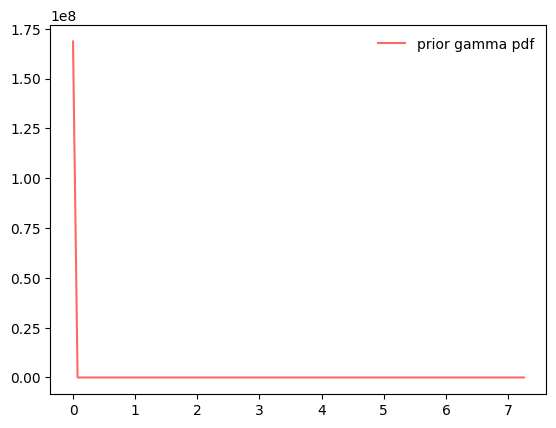

In [33]:
# plot prior distribution function
x_plt_gamma = np.linspace(stats.gamma.ppf(0.01, **prior_params), stats.gamma.ppf(0.99, **prior_params), 100)
plt.plot(x_plt_gamma, stats.gamma.pdf(x_plt_gamma, **prior_params),'r-', alpha=0.6, label='prior gamma pdf')
plt.legend(loc='best', frameon=False)
plt.show()

In [34]:
prior_stats = stats.gamma.stats(**prior_params, moments='mv')
print("Prior (mean / var): ({} / {})".format(prior_stats[0], prior_stats[1]))

Prior (mean / var): (0.6153846153846154 / 2.1452991452991457)


#### Posterior $P(\lambda|x)$ 

The posterior distribution of $\lambda$ is $\Gamma(\alpha\prime, \beta\prime)$ distribution with $\alpha\prime = \alpha + \sum_{i=1}^{n} x_i$ and $\beta\prime = \beta + n$.

In [35]:
# posterior hyper params
def posterior_hyper_params(a, scale):
    alpha_prime = float(a + x.sum())
    beta_prime = float(1/scale + len(x))
    return {'a':alpha_prime, 'scale': 1/beta_prime}

posterior_params = posterior_hyper_params(**prior_params)

In [36]:
# example quantiles
q_orders = [0.001, 0.01, 0.1, 0.5, 0.75, 0.9, 0.99]
q = stats.gamma.ppf(q_orders, **posterior_params)
print("Posterior probabilities:")
for i in range(0,len(q_orders)):
    print(".. lambda <= {}:\t{} %".format(round(q[i],2), 100*q_orders[i]))
    
print("")
ci_lambda_posterior = stats.gamma.interval(0.95, **posterior_params)
P_ci_lambda_posterior = stats.gamma.cdf(ci_lambda_posterior[1], **posterior_params)-stats.gamma.cdf(ci_lambda_posterior[0], **posterior_params)
print("Posterior probability:")
print("P({} <= lambda <= {} | x) = {} %".format(ci_lambda_posterior[0], ci_lambda_posterior[1], round(100*P_ci_lambda_posterior,2)))

Posterior probabilities:
.. lambda <= 0.3:	0.1 %
.. lambda <= 0.36:	1.0 %
.. lambda <= 0.46:	10.0 %
.. lambda <= 0.61:	50.0 %
.. lambda <= 0.69:	75.0 %
.. lambda <= 0.78:	90.0 %
.. lambda <= 0.94:	99.0 %

Posterior probability:
P(0.39500305603131636 <= lambda <= 0.8838379418323971 | x) = 95.0 %


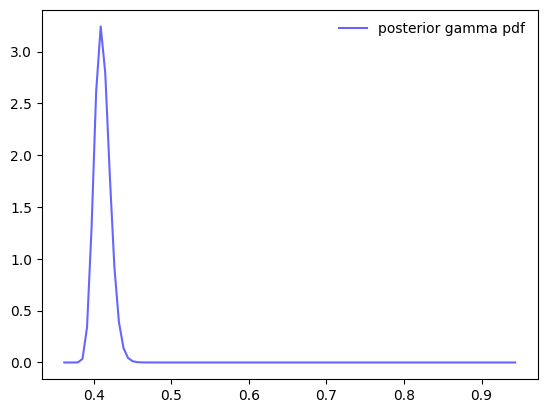

In [37]:
# plot posterior distribution function
x_plt_posterior_gamma = np.linspace(stats.gamma.ppf(0.01, **posterior_params), stats.gamma.ppf(0.99, **posterior_params), 100)
plt.plot(x_plt_posterior_gamma, stats.gamma.pdf(x_plt_gamma, **posterior_params),'b-', alpha=0.6, label='posterior gamma pdf')
plt.legend(loc='best', frameon=False)
plt.show()

In [38]:
posterior_stats = stats.gamma.stats(**posterior_params, moments='mv')
print("Posterior (mean / var): ({} / {})".format(posterior_stats[0], posterior_stats[1]))

Posterior (mean / var): (0.6153846153846154 / 0.015663881803218586)


#### Highest Density Interval (HDI) of the Posterior

The posterior distribution knows a `.interval` method. The docs describe it as 
> Confidence interval with equal areas around the median.

The HDI is the shortest interval that contains, for instance $\alpha=95\$%, of the probability. This is not necessarily the equal area around the median.

Let $\theta_1, \theta_2$ the two limits of the HDI, with $\theta_1 \lt \theta_2$. For the HDI  the following constraints hold:

$$
F(\theta_2 | X) - F(\theta_1 | X) = \alpha
\\
f(\theta_1 | X) = f(\theta_2 | X)
$$

This is an optimization problem.

In [39]:
# Source: 
# https://jakevdp.github.io/blog/2014/06/12/frequentism-and-bayesianism-3-confidence-credibility/#3.-Frequentist-approach-#2:-Exact-Sampling-Distribution
def HDI(alpha, distr, params):

    def f(theta):
        return distr.pdf(theta, **params)

    def F(theta):
        return distr.cdf(theta, **params)
    
    
    def eqns(CI):
        """Equations which should be equal to zero"""
        theta1, theta2 = CI
        return (F(theta2) - F(theta1) - alpha,
                f(theta2) - f(theta1))
    
    guess = distr.ppf([0.01,0.99], **params)
    result = optimize.root(eqns, guess)
    return result

In [40]:
hdi_res = HDI(alpha, stats.gamma, posterior_params)
if not hdi_res.success:
    print("warning: CI result did not converge!")
else:
    hdi = hdi_res.x
    print("")
    print("{}% HDI of posterior distribution for lambda: {}\n".format(alpha*100, hdi))


95.0% HDI of posterior distribution for lambda: [0.38054376 0.8648511 ]



#### Posterior Predictive $P(\hat{x}|x)$ 

In [41]:
# neg. binomial params
alpha_prime = posterior_params['a']
beta_prime = 1/posterior_params['scale']

nb_n = alpha_prime
nb_p = beta_prime / (1+beta_prime)

nb_n, nb_p

(24.176524670548574, 0.9751780063291139)

In [42]:
# P(x^ <= 0 | x)
# The probability to observe no event of stock1 exceeding c 
# within the next bin of width b
posterior_predictive = stats.nbinom.cdf(0, nb_n, nb_p)

In [43]:
print("Probability to observe NO / at least ONE event")
print(".. of {} slope exceeding {}, ".format(stock1_name, round(c,3)))
print(".. within the next {} days,".format(round(0-x_bin_edges[-2],2)))
print("= {}% / {}%".format(round(posterior_predictive*100,2), round(100*(1-posterior_predictive),2)))

Probability to observe NO / at least ONE event
.. of MUX.DE slope exceeding 0.294, 
.. within the next 6.21 days,
= 54.46% / 45.54%


#### Bayesian Analysis looping through `num_bins`

In [85]:
# store bayes results for different num of bins
res_stock1_slope_bayes = []
alpha = 0.95
all_bins = range(2, -days_back_exceeds_c.iloc[0]+1)

# loop through all bin numbers
for num_bins in all_bins:
    bin_edges = _bin_edges(num_bins)
    x, x_bin_edges = np.histogram(days_back_exceeds_c.values, bins=bin_edges, density=False)
    bin_width = round(0-x_bin_edges[-2],2)

    # Bayesian confidence intervals for the mean and var (lambda_hat)
    # using an uninformed prior
    bayes_lambda_hat, bayes_lambda_hat_var, bayes_lambda_hat_std = stats.bayes_mvs(x, alpha=alpha)
    point_lambda_hat = bayes_lambda_hat[0]
    point_lambda_hat_var = bayes_lambda_hat_var[0]

    try:
        assert point_lambda_hat_var < float('inf'), "Invalid variance for lambda_hat"
    except AssertionError:
        continue
        
    # we initialize an informative prior, i.e., with previously known mean and var 
    # here: prior's mean and var = bayes_mvs
    prior_params = prior_hyper_params(point_lambda_hat, point_lambda_hat_var)

    # lambda's posterior distribution 
    posterior_params = posterior_hyper_params(**prior_params)
    posterior_stats = stats.gamma.stats(**posterior_params, moments='mv')
    posterior_lambda_mean = float(posterior_stats[0])
    posterior_lambda_var = float(posterior_stats[1])

    # lambda's HDI 
    hdi_res = HDI(alpha, stats.gamma, posterior_params)
    if hdi_res.success:
        lambda_hdi = hdi_res.x
    else:
        lambda_hdi = float("NaN")

    # compute posterior predictive P(x^ <= 0 | x)
    # i.e. the probability to observe no event of stock1 exceeding c 
    # within the next bin of width b

    # neg. binomial params
    alpha_prime = posterior_params['a']
    beta_prime = 1/posterior_params['scale']
    nb_n = alpha_prime
    nb_p = beta_prime / (1+beta_prime)

    # posterior predictive P(x^ <= 0 | x)
    posterior_predictive = stats.nbinom.cdf(0, nb_n, nb_p)
    # P(x^ <= 0 | x)
    P_x_hat_leq0 = posterior_predictive
    # P(x^ > 0 | x)
    P_x_hat_gt0 = 1-posterior_predictive
    
    # add to result list
    res_stock1_slope_bayes.append((num_bins, bin_width, posterior_lambda_mean, posterior_lambda_var, lambda_hdi, P_x_hat_leq0, P_x_hat_gt0))

In [88]:
# compile dataframe from result list
num_bins_indices = [num_bin for num_bin in list(zip(*res_stock1_slope_bayes))[0]]
colnames = ['num_bins', 'bin_width', 'lambda_mean', 'lambda_var', 'lambda_hdi', 'P_x_hat_leq0', 'P_x_hat_gt0']
stock1_slope_bayes = pd.DataFrame(data=res_stock1_slope_bayes, columns=colnames, index=num_bins_indices).dropna()
stock1_slope_bayes.index.name = colnames[0]
stock1_slope_bayes = stock1_slope_bayes.drop(labels=stock1_slope_bayes.index.name, axis=1)

### Compile and Store Final Result

In [91]:
# compile final result
stock1_slope_predictability = ()
stock1_slope_predictability = stock1_slope_entropy.join(stock1_slope_chi2, how='inner')
stock1_slope_predictability = stock1_slope_predictability.join(stock1_slope_bayes, how='left')

In [92]:
stock1_slope_predictability.head()

,dist,Hbits,Sbits,Bbits,min_n,chi2_pvalue,bin_width,lambda_mean,lambda_var,lambda_hdi,P_x_hat_leq0,P_x_hat_gt0
num_bins,,,,,,,,,,,,
2,5.126919,0.918296,4.584963,1.000000,8,0.102470,NaN,NaN,NaN,NaN,NaN,NaN
3,4.386342,1.382437,4.584963,1.584963,3,0.043937,NaN,NaN,NaN,NaN,NaN,NaN
4,3.859184,1.715771,4.584963,2.000000,3,0.011726,60.50,6.0,1.466667,"[3.7265569565423435, 8.413847703440517]",0.004664,0.995336
5,3.498071,1.910762,4.584963,2.321928,0,0.044856,48.40,4.8,0.922167,"[2.9963678438963943, 6.7139346404520746]",0.012393,0.987607
6,3.116424,2.198120,4.584963,2.584963,0,0.062246,40.33,4.0,0.636364,"[2.5014370776572328, 5.589889499403643]",0.024429,0.975571


In [116]:
# entropy-based best uniform binning using min distance
min_dist_idx = stock1_slope_predictability['dist'].idxmin()
best_bin_num_entropy = min_dist_idx
print("Best number of bins (entropy based): {}\n".format(best_bin_num_entropy))
stock1_slope_predictability.loc[best_bin_num_entropy]

Best number of bins (entropy based): 39



dist                                               1.82
Hbits                                          2.901364
Sbits                                          4.584963
Bbits                                          5.285402
min_n                                                 0
chi2_pvalue                                         0.0
bin_width                                          6.21
lambda_mean                                    0.615385
lambda_var                                     0.015664
lambda_hdi      [0.380543761068307, 0.8648510976490941]
P_x_hat_leq0                                   0.544611
P_x_hat_gt0                                    0.455389
Name: 39, dtype: object

In [118]:
# chi2 based best uniform binning
try:
    min_chi2_pvalue = stock1_slope_predictability[stock1_slope_predictability['min_n']>5]['chi2_pvalue'].idxmin()
    best_bin_num_chi2 = stock1_slope_predictability.loc[min_chi2_pvalue]['min_n']
    print("Best number of bins (chi2 for uniformity): {}\n".format(best_bin_num_chi2))
    print(stock1_slope_predictability.loc[min_chi2_pvalue])
except Exception:
    print("No best chi2-based binning found.")
    best_bin_num_chi2 = 0

Best number of bins (chi2 for uniformity): 8

dist            5.126919
Hbits           0.918296
Sbits           4.584963
Bbits                1.0
min_n                  8
chi2_pvalue      0.10247
bin_width            NaN
lambda_mean          NaN
lambda_var           NaN
lambda_hdi           NaN
P_x_hat_leq0         NaN
P_x_hat_gt0          NaN
Name: 2, dtype: object


In [142]:
# Bayesian analysis for best num bins of entropy, chi2 and about the next 14 days 
next_days = 14
next_days_idx = stock1_slope_predictability[stock1_slope_predictability['bin_width'] <= next_days]['bin_width'].idxmax()

num_bins_idx = [(best_bin_num_entropy, 'best num_bin entropy-based'), (best_bin_num_chi2, 'best num_bin chi2 uniformity'), (next_days_idx, 'next {} days'.format(next_days))]
num_bins_idx.sort()

for num_bins,approach in num_bins_idx:
    bin_width = stock1_slope_predictability.loc[num_bins]['bin_width']
    P_x_hat_leq0 = stock1_slope_predictability.loc[num_bins]['P_x_hat_leq0']
    P_x_hat_gt0 = stock1_slope_predictability.loc[num_bins]['P_x_hat_gt0']

    print("=== Approach: {} ===".format(approach))
    print("Probability to observe NO / at least ONE event")
    print(".. of {} slope exceeding {}, ".format(stock1_name, round(c,3)))
    print(".. within the next {} days,".format(bin_width))
    print("= {}% / {}%".format(round(P_x_hat_leq0*100,2), round(100*P_x_hat_gt0,2)))
    print("")

=== Approach: best num_bin chi2 uniformity ===
Probability to observe NO / at least ONE event
.. of MUX.DE slope exceeding 0.294, 
.. within the next 30.25 days,
= 5.89% / 94.11%

=== Approach: next 14 days ===
Probability to observe NO / at least ONE event
.. of MUX.DE slope exceeding 0.294, 
.. within the next 13.44 days,
= 27.31% / 72.69%

=== Approach: best num_bin entropy-based ===
Probability to observe NO / at least ONE event
.. of MUX.DE slope exceeding 0.294, 
.. within the next 6.21 days,
= 54.46% / 45.54%

